# Deploy ML Model to Azure IoT Edge


In this exercise, we introduce the steps of deploying an ML module through [Azure IoT Edge](https://docs.microsoft.com/en-us/azure/iot-edge/how-iot-edge-works). The purpose is to deploy a trained image classification model to the edge device. When the image data is generated from a particular process pipeline and fed into the edge device, the deployed model is able to make predictions right on the edge device without accessing to the cloud. 


## Outline<a id="BackToTop"></a>
- [Prerequisite](#prerequisite)
- [Step 1: Build the trained ML Model into Docker Image](#step1)
- [Step 2: Provision and Configure IoT Edge Device](#step2)
- [Step 3: Deploy ML Module on IoT Edge Device](#step3)
- [Step 4: Test ML Module](#step4)

## Prerequisite <a id="Prerequisite"></a>

Before starting this notebook, you should finish [Keras_TF_CNN_DeployModel.ipynb](Keras_TF_CNN_DeployModel.ipynb) in the same repository (except the last section "Clean up resources"). As a recap, we have created following resources in step "Deploy model as a Web Service" in this previous execercise:
    
    - Resource group defined in variable YOUR_RESOURCE_GROUP
        * Machine Learning Model Management
        * cluster environment (Microsoft.MachineLearningCompute/operationalizationClusters)
    - Resource group created during the cluster environment provision (YOUR_RESOURCE_GROUP plus "-azureml-xxxxx") 
        * Container registry
        * Container service
        * .... a bunch of other automatically provisoned resources

In this notebook, we will be using *Machine Learning Model Managment*, and *Container registry* in later instructions. You need to find relevant information about these resources from [Azure portal](https://portal.azure.com). Also keep in mind that they are from two differnt resource group when you locate them from the Azure portal. 

## Step 1: Build the trained ML Model into Docker Image <a id="step1"></a>

If you have finished [Prerequisite](#prerequisite), you can skip this step. Otherwise, you can follow Section *Create the Azure ML container* in [Deploy Azure Machine Learning as an IoT Edge module - preview](https://docs.microsoft.com/en-us/azure/iot-edge/tutorial-deploy-machine-learning) to deploy your own ML model. The expected output of this step include:

    1. A docker image hosted on ACR (Azure Container Registry). This image will be used to create a docker container running on the edge device. 
    2.  A web service. This web service can be used for testing purpose.

## Step 2: Provision and Configure IoT Edge Device <a id="step2"></a>

In [Azure portal](https://portal.azure.com) we need to create following resources in YOUR_RESOURCE_GROUP.

Resource 1: An IoT hub. Please follow the sections *Create an IoT hub* and *Register an IoT Edge device* in document [Deploy Azure IoT Edge on a simulated device in Linux or MacOS - preview](https://docs.microsoft.com/en-us/azure/iot-edge/tutorial-simulate-device-linux). After finishing these instructions, copy the value for **Connection string—primary key** from the IoT Edge Device page and save it to *ConnectionString* in the next cell. Notice that we need to have double quote in the command. You will need to execute this command in later instructions.

In [4]:
ConnectionString = '"Your Connection string"'
print('sudo iotedgectl setup --connection-string ', ConnectionString, ' --nopass')

sudo iotedgectl setup --connection-string  "Your Connection string"  --nopass


Resource 2: A Linux VM serving as the edge device. You can use the same Linux deep learning VM you have provisioned for running Keras_TF_CNN_DeployModel.ipynb (Or alternatively, you can use another Linux VM, e.g. Ubuntu server 16.04 LTS). The goal is to configure the VM so that it can run IoT Edge runtime and Docker. To finish the configuration, please follow the Sections *Prerequisites* and *Install and start the IoT Edge runtime* in document [Deploy Azure IoT Edge on a simulated device in Linux or MacOS - preview](https://docs.microsoft.com/en-us/azure/iot-edge/tutorial-simulate-device-linux).

   【Tips】: When you are at [this page](https://docs.docker.com/install/linux/docker-ce/ubuntu/#prerequisites), you probably only need to finish sections *Prerequisites - Uninstall old versions* and *Install Docker CE - Install using the repository*. You will also need to use the command generated from the previous cell when following *Install and start the IoT Edge runtime* in document [Deploy Azure IoT Edge on a simulated device in Linux or MacOS - preview](https://docs.microsoft.com/en-us/azure/iot-edge/tutorial-simulate-device-linux).

## Step 3: Deploy ML Module on IoT Edge Device <a id="step3"></a>

In an IoT application, modules are function units on an edge device. The output of one module can serve as the input of another module. We often need multiple modules on the same IoT Edge device working together to achieve the realtime data analytics pipeline. ML module is typically one of them. The ML module takes input from a data module, and produces the prediction result as the output.

We need following two steps to deploy ML module on IoT Edge device.

a: Configure iot edge devce. 

Since our docker image is hosted on a private container registry (i.e. Azure container registry), please follow Section *Add registry credentials to your Edge device* in document [Deploy Azure Machine Learning as an IoT Edge module - preview](https://docs.microsoft.com/en-us/azure/iot-edge/tutorial-deploy-machine-learning). 

【Tips】: You need to go to Azure portal to find out information about your container registry. Notice that the name of your resource group is likely to be YOUR_RESOURCE_GROUP plus "-azureml-xxxxx". Please see below screenshots for your reference. Save relevant information including *Login server*, *User name*, and *password* into the variables in the next cell. You will need to use the command generated from the next cell to finish this step.

![containerregistry](./imgs/containerRegistry.PNG)

![containerregistry2](./imgs/containerRegistry2.PNG)


In [11]:
registryLoginServer = "Login_server" # replace with the real Login Server
registryUsername = "User_name" # replace with the real User name
registryPassword = "password" # replace with the real password
# No double quotes are needed in this command.
print('sudo iotedgectl login --address', registryLoginServer, '--username ', registryUsername, '--password', registryPassword)

sudo iotedgectl login --address Login_server --username  User_name --password password


b: Deploy ML module
    
Essentially, the objective is to deploy the ML container to the IoT Edge device.

1. On the Azure portal, navigate to your IoT hub.
2. Click *IoT Edge (preview)* and select your IoT Edge device.
3. Select *Set modules*.
4. Select *Add IoT Edge Module*.
5. In the Name field, enter a name, `yourmodulename`. 
6. In the Image field, enter your image location; for example `mlcrpacrdf78885275b6.azurecr.io/yanzimgclussrvc:1`.
    
    【Tips】: You can find the image location in your machine learning account manamgement - `Model Management` - `Images` - click the image you have created - copy the address from `Location` field. Please see below screenshots for your reference.
    
7. In the *Container Create Options* field, set the following configuration. You can change the HostPort Binding port number to your desired port number. 

    {
      "HostConfig": {
        "PortBindings": {
          "5001/tcp": [
            {
              "HostPort": "5001"
            }
          ]
         }
        }
       }

8.	Click *Save*.
9.	Back in the *Add Modules* step, click *Next*.
10.	In the *Specify Routes* step. Put the following:
      {}      
      
11.	Select Next.
12.	In the *Review Deployment* step, click *Submit*.
13.	Return to the device details page and click *Refresh*. You should see the new `yourmodulename` running.




![mm](./imgs/modelmanagement.PNG)

![mm2](./imgs/modelmanagement2.PNG)
    
    
An alternative example you can reference is the section *Run the solution* in document [Deploy Azure Machine Learning as an IoT Edge module - preview](https://docs.microsoft.com/en-us/azure/iot-edge/tutorial-deploy-machine-learning).

In [23]:
# Check if the image, scoring script and model are in the same folder.
os.listdir(model_path)

['score.py', 'kerastfmodel.h5', 'automobile8.png']

In [24]:
# Change the current working directory to model_path
os.chdir(model_path)
#list files in current working directory
os.listdir(os.curdir)

['score.py', 'kerastfmodel.h5', 'automobile8.png']

## Step 4: Test ML Module <a id="step4"></a>

Now we have deployed your ML model as a module on the IoT edge device. How to test it and make sure it functions correctly?	

First of all, we should test the deployed web service and make sure it works. We assume this step has been completed in step "Test Web Service" in our previous exercise [Keras_TF_CNN_DeployModel.ipynb](./Keras_TF_CNN_DeployModel.ipynb). 
Secondly, we can test to score the deployed ML module from the IoT edge device with the service endpoint url address. We will show detailed instructions for this approach in the remaining of this section.

In [31]:
# make sure you have correct working directory settings
import os
local_path = os.getcwd()
o16n_path = os.path.join(local_path,'o16n')  
model_path = os.path.join(o16n_path,'kerastfmodel')
model_path

'/home/mylogin/notebooks/DeepLearningModelDeployment/o16n/kerastfmodel/o16n/kerastfmodel'

In [16]:
# Change the current working directory to model_path
os.chdir(model_path)
#list files in current working directory
os.listdir(os.curdir)

['conda_dependencies.yml', 'score.py', 'kerastfmodel.h5', 'automobile8.png']

In [27]:
# service endpoint url address
url = 'Your Scoring URL Here!!'
#url = 'http://137.117.32.176:5001/score'
#url = 'http://localhost:5001/score'

The service endpoint url address should have the format of "http://localhost:[port_number]/score" or "http://[edge_device_ip]:[port_number]/score". If your ipython notebook and ML module are running from the same VM, you can use `localhost`. Otherwise you should use the ip address of the edge device VM. The `port_number` is predefined in step b of [Deploy ML Module on IoT Edge Device](#step3).

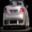

In [19]:
from PIL import Image
# the test image to predict on
test_img_name = 'automobile8.png'
Image.open(test_img_name)

In [22]:
import base64
import json

img_file_name = os.path.split(test_img_name)[1]
print(img_file_name)
# prepare a test image
with open(test_img_name, 'rb') as file:
  encoded = base64.b64encode(file.read())
img_dict = {img_file_name: encoded.decode('utf-8')}
body = json.dumps(img_dict)

automobile8.png


In [29]:
import requests

# call the web service end point
headers = {'Content-Type':'application/json'}
response = requests.post(url, headers=headers, data=body)
response

<Response [200]>

The output from above cell should be `<Response [200]>`.

In [30]:
prediction = json.loads(response.content.decode('ascii'))
prediction # The firt part is the test image's name, and the second part is the predicted category. 

'[{"automobile8.png": "automobile"}]'

### Clean up resources <a id="cleanup"></a>

When you finish this example, you may want to avoid unnecessary cost by cleaning up the Azure resources you have provisioned. You need to delete two resource groups: YOUR_RESOURCE_GROUP and YOUR_RESOURCE_GROUP plus"-azureml-xxxxx". The exact name for the second resource group can be found in your Azure portal. For example, my resource group name is YOUR_RESOURCE_GROUP = "yanzimgrg" and the other system created resource group name is "yanzimgrg-azureml-a0c61". I then need to execute following commands to delete these two resource groups.

    az group delete -n yanzimgrg
    az group delete -n yanzimgrg-azureml-a0c61

In [44]:
# Delete resource group. Execute this command in the console. 
# Execute below command in CLI console, at the prompt type "y" (Q: Are you sure you want to perform this operation? (y/n):) 
# az group delete -n $YOUR_RESOURCE_GROUP
print("az group delete -n ", YOUR_RESOURCE_GROUP)

az group delete -n  yanzimgrg
